<a href="https://colab.research.google.com/github/Johnne32/Hamoye-Stage-D-work/blob/master/Hamoye_Stage_D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing libraries and Loading the data



In [1]:
# Importing needed libraries

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

In [2]:
# Mnist comes with Keras by default so simply load the test and train files using the codes below

mnist= keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels)=mnist.load_data()

## Exploring the data

The mnist dataset is a collection of 28 x 28 pixel images showing hand-drawn representations of the digits 0-9, or what we will refer to as 10 classes.
Every mnist datapoint has two parts: the image of a handwritten digit (x) and the corresponding label(y), Both the training set and the test set contains images and the corresponding labels.


In [3]:
# Let's have a look at the shape of the datasets

print("Training data: {}, {}".format(train_images.shape, train_labels.shape))
# prints Training data: (60000, 28, 28), (60000,)
print("Test data: {}, {}".format(test_images.shape, test_labels.shape))
# prints Test data: (10000, 28, 28), (10000,)

Training data: (60000, 28, 28), (60000,)
Test data: (10000, 28, 28), (10000,)


In [4]:
class_labels = np.unique(train_labels)
print("There are {} classes in the dataset. They are: {}".format(len(class_labels), class_labels))

There are 10 classes in the dataset. They are: [0 1 2 3 4 5 6 7 8 9]


Text(0.5, 1.0, 'Label: 5')

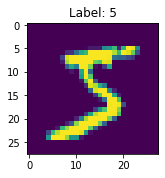

In [5]:
# Let's plot and look at a few images 

plt.figure(figsize=(8, 5))

plt.subplot(1,3,1)
plt.imshow(train_images[0])
plt.title("Label: {}".format(train_labels[0]))

Text(0.5, 1.0, 'Label: 0')

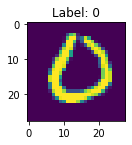

In [6]:
plt.subplot(1,3,2)
plt.imshow(train_images[2500])
plt.title("Label: {}".format(train_labels[2500]))


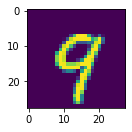

In [7]:
plt.subplot(1,3,3)
plt.imshow(test_images[12])
plt.show()




## Data Preprocessing

We would first of all normaize the images pixel values. Pixel values are often unsigned integers in the range between 0 and 255. Although these pixel values can be presented directly to neural network models in their raw format, this can result in challenges during modeling, such as in the slower than expected training of the model.

Instead, there can be great benefit in preparing the image pixel values prior to modeling, such as simply scaling pixel values to the range 0-1 to centering and even standardizing the values.

In [8]:
# As usual, we scale our dataset to range between 0 and 1. In this dataset, the pixel values range from 0 to 255.
# Dividing the data by 255 scales to the required range. This normalization is done to help with the training.

train_images = train_images / 255.0
test_images = test_images / 255.0


We then partition this dataset further and create a validation set. In other words, a training set is used to fit the parameters, validation set is used to tune the parameters while the trained classifier is evaluated on the test set.

In [9]:
x_train = train_images[0:50000]
x_val = train_images[50000:]
y_train = train_labels[0:50000]
y_val = train_labels[50000:]

print("x_train: {}".format(x_train.shape)) # prints x_train: (50000, 28, 28)
print("x_val: {}".format(x_val.shape)) # prints x_val: (10000, 28, 28)
print("y_train: {}".format(y_train.shape)) #prints y_train: (50000,)
print("y_val: {}".format(y_val.shape)) #prints y_val: (10000,)

x_train: (50000, 28, 28)
x_val: (10000, 28, 28)
y_train: (50000,)
y_val: (10000,)


Now we one-hot code the categorical column(y in this case). In one-hot encoding, we convert the categorical data into a vector of numbers i.e converting class vectors to binary class vectors(0 and 1). we do this because machine learning algorithms can't work with categorical data directly.

The one-hot encoding will be a row vector, and for each image, it will have a dimension of 1 x 10. It's important to note that the vector consists of all zeros except for the class that it represents,there, you'll find a 1. For example 3 translates to [0 0 0 1 0 0 0 0 0 0] and 9 translates to [0 0 0 0 0 0 0 0 0 1]. Note that no_labels also refers to the number of classes which is 10.

In [10]:
# one-hot encoding using keras' numpy-related utilities

from tensorflow.keras.utils import to_categorical
no_labels = 10
y_train = to_categorical(y_train, no_labels)
y_val = to_categorical(y_val, no_labels)
y_test = to_categorical(test_labels, no_labels)

As with all machine learning, the models are very picky about the format of the input data. We need to to reshape the 28x28 image arrays into 784-unit vectors. This is necessary because the first layer of the network is expecting a vector input.


In [11]:
# Flattening the images from the 2D 28x28 pixels to 1D 784 pixels

new_dimension = np.prod(train_images.shape[1:])
x_train = x_train.reshape(x_train.shape[0], new_dimension)
x_val = x_val.reshape(x_val.shape[0], new_dimension)
test_images = test_images.reshape(test_images.shape[0], new_dimension)

print("x_train: {}".format(x_train.shape)) #prints  x_train: (50000, 784)
print("x_val: {}".format(x_val.shape)) #prints x_val: (10000, 784)
print("test_images: {}".format(test_images.shape)) #prints test_images: (10000, 784)

x_train: (50000, 784)
x_val: (10000, 784)
test_images: (10000, 784)


We will now define an input placeholder X, which will have a dimension of None x 784 (new_dimension= 784) and the output placeholder with a dimension of None x 10.  

A placeholder is simply a variable that we will assign data to at a later date. It allows us to create our operations and build our computation graph, without needing the data. In TensorFlow terminology, we then feed data into the graph through these placeholders. The first dimension of the placeholder is None, meaning we can have any number of rows.

In [12]:
# inputs
#placeholders are not enabled in tf 2
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
X = tf.placeholder(tf.float32, [None, new_dimension])
Y = tf.placeholder(tf.float32, [None, no_labels])


Instructions for updating:
non-resource variables are not supported in the long term


## Building the model architecture

In [13]:
# create model architecture
def multilayer_perceptron(x, no_classes, first_layer_neurons=256, second_layer_neurons=128):
  # first layer
  first_weight = tf.Variable(tf.random_uniform([new_dimension, first_layer_neurons]))
  first_bias = tf.Variable(tf.zeros([first_layer_neurons]))
  first_layer_output = tf.nn.relu(tf.add(tf.matmul(x, first_weight), first_bias))
  # second layer
  second_weight = tf.Variable(tf.random_uniform([first_layer_neurons,second_layer_neurons]))
  second_bias = tf.Variable(tf.zeros([second_layer_neurons]))
  second_layer_output = tf.nn.relu(tf.add(tf.matmul(first_layer_output, second_weight), second_bias))
  # output layer
  final_weight = tf.Variable(tf.random_uniform([second_layer_neurons, no_classes]))
  final_bias = tf.Variable(tf.zeros([no_classes]))
  logits = tf.add(tf.matmul(second_layer_output, final_weight), final_bias)

  return logits



In [14]:
logits = multilayer_perceptron(X, no_labels)
learning_rate = 0.01
#we define the loss and optimiser for the network
loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=Y))
optimiser = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimiser.minimize(loss_op)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



## Running the model

In [15]:

#initialise the variables
init = tf.global_variables_initializer()

epochs = 20
batch_size = 1000
iteration = len(x_train) // batch_size
#train model
with tf.Session() as session:
  session.run(init)
  for epoch in range(epochs):
    average_cost = 0
    start, end = 0, batch_size
    for i in range(iteration):
      batch_x, batch_y = x_train[start: end], y_train[start: end]
      _, loss = session.run([train_op, loss_op], feed_dict={X: batch_x, Y: batch_y})
      start += batch_size
      end += batch_size 
      #average loss
      average_cost += loss/iteration
    print("Epoch========{}".format(epoch))
    #evaluate model
  prediction = tf.nn.softmax(logits)
  ground_truth = tf.equal(tf.argmax(prediction, 1), tf.argmax(Y, 1))
  accuracy = tf.reduce_mean(tf.cast(ground_truth, "float"))
  print("Accuracy: {}".format(accuracy.eval({X: test_images, Y: y_test})))
    

   

Epoch========0
Epoch========1
Epoch========2
Epoch========3
Epoch========4
Epoch========5
Epoch========6
Epoch========7
Epoch========8
Epoch========9
Epoch========10
Epoch========11
Epoch========12
Epoch========13
Epoch========14
Epoch========15
Epoch========16
Epoch========17
Epoch========18
Epoch========19
Accuracy: 0.9050999879837036


## Optimization for training deep neural networks

In [16]:
#Building a Sequential Feed Forward Network in Keras

from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
#Build the model object
model = Sequential()
# Build the input and the hidden layers
model.add(Dense(256, activation='relu', input_shape=(new_dimension,)))
model.add(Dense(128, activation='relu'))
# Build the output layer
model.add(Dense(no_labels, activation='softmax'))




Now that the model is in place, we configure the learning process using .compile(). Here we specify our loss function (or objective function). For our setting categorical cross entropy fits the bill, but in general other loss functions are available. 

As for the optimizer of choice we'll use Adam with default settings. We could also instantiate an optimizer and set parameters before passing it to model.compile() but for this example the defaults will do.

We also choose which metrics will be evaluated during training and testing. We can pass any list of metrics - even build metrics ourselves - and have them displayed during training/testing.

In [17]:
model.compile(optimizer='adam', loss=tf.keras.losses.categorical_crossentropy, 
              metrics=['accuracy'])


Having compiled our model we can now start the training process. We have to specify how many times we want to iterate on the whole training set (epochs) and how many samples we use for one update to the model's weights (batch size).

In [18]:
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=20, batch_size=1000)

test_loss, test_accuracy = model.evaluate(test_images, y_test)
print('Test loss: {}'.format(test_loss))
print('Test accuracy: {}'.format(test_accuracy))

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
49000/50000 [============================>.] - ETA: 0s - loss: 0.7083 - acc: 0.8119WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training_v1.py:2048: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
50000/50000 [==============================] - 1s 30us/sample - loss: 0.7006 - acc: 0.8141 - val_loss: 0.2577 - val_acc: 0.9246
Epoch 2/20
50000/50000 [==============================] - 1s 28us/sample - loss: 0.2363 - acc: 0.9321 - val_loss: 0.1824 - val_acc: 0.9488
Epoch 3/20
50000/50000 [==============================] - 1s 28us/sample - loss: 0.1713 - acc: 0.9509 - val_loss: 0.1472 - val_acc: 0.9576
Epoch 4/20
50000/50000 [==============================] - 1s 28us/sample - loss: 0.1324 - acc: 0

Text(0.5, 1.0, 'Loss Curves - before regularisation')

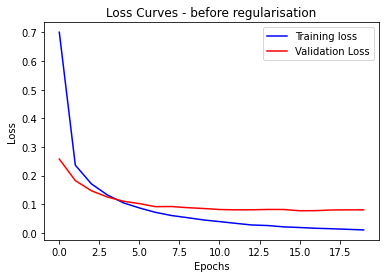

In [19]:
#Check for Overfitting

plt.figure()
plt.plot(history.history['loss'], 'blue')
plt.plot(history.history['val_loss'], 'red')
plt.legend(['Training loss', 'Validation Loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curves - before regularisation')


In [20]:
from tensorflow.keras.layers import Dropout
reg_model = Sequential()
reg_model.add(Dense(256, activation='relu', input_shape=(new_dimension,)))
reg_model.add(Dropout(0.4))
reg_model.add(Dense(128, activation='relu'))
reg_model.add(Dropout(0.4))
reg_model.add(Dense(no_labels, activation='softmax'))

reg_model.compile(optimizer='adam', loss=tf.keras.losses.categorical_crossentropy, 
              metrics=['accuracy'])

reg_history = reg_model.fit(x_train, y_train, validation_data=(x_val, y_val), 
                            epochs=20, batch_size=1000)
test_loss, test_accuracy = reg_model.evaluate(test_images, y_test)
print('Test loss: {}'.format(test_loss))
print('Test accuracy: {}'.format(test_accuracy))

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 2s 35us/sample - loss: 1.0000 - acc: 0.6853 - val_loss: 0.2983 - val_acc: 0.9158
Epoch 2/20
50000/50000 [==============================] - 2s 35us/sample - loss: 0.3864 - acc: 0.8871 - val_loss: 0.2050 - val_acc: 0.9412
Epoch 3/20
50000/50000 [==============================] - 2s 35us/sample - loss: 0.2875 - acc: 0.9161 - val_loss: 0.1649 - val_acc: 0.9533
Epoch 4/20
50000/50000 [==============================] - 2s 36us/sample - loss: 0.2440 - acc: 0.9302 - val_loss: 0.1414 - val_acc: 0.9599
Epoch 5/20
50000/50000 [==============================] - 2s 36us/sample - loss: 0.2074 - acc: 0.9392 - val_loss: 0.1255 - val_acc: 0.9637
Epoch 6/20
50000/50000 [==============================] - 2s 36us/sample - loss: 0.1808 - acc: 0.9466 - val_loss: 0.1157 - val_acc: 0.9670
Epoch 7/20
50000/50000 [==============================] - 2s 35us/sample - loss: 0.1652 - acc: 0.9514 - val_loss: 0.

In [21]:
test_loss, test_accuracy = reg_model.evaluate(test_images, y_test)
print('Test loss: {}'.format(test_loss))
print('Test accuracy: {}'.format(test_accuracy))


Test loss: 0.07277523294225102
Test accuracy: 0.9789000153541565


Text(0.5, 1.0, 'Loss Curves - after regularisation')

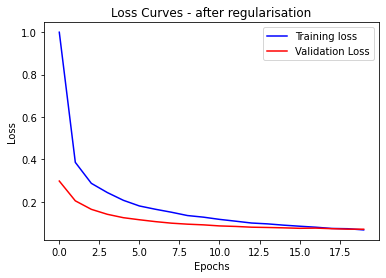

In [22]:
plt.figure()
plt.plot(reg_history.history['loss'], 'blue')
plt.plot(reg_history.history['val_loss'], 'red')
plt.legend(['Training loss', 'Validation Loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curves - after regularisation')

## Making Predictions

I added this just for more clarity and understanding. Let's use our model to predict some images and labels.

In [23]:
predictions = model.predict([test_images]) # Make prediction
print(np.argmax(predictions[1000])) # Print out 9

9


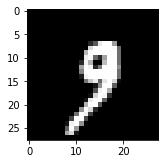

In [24]:
# Let's see whether the image would turn out to be 9
# Remember that the input data to the network were flattened for the purpose of learning to a vector with a length of 784. Before displaying it, we need to convert it back to the size of 28 x 28 pixels.
plt.figure(figsize=(8, 5))

plt.subplot(1,3,1)
plt.imshow(test_images[1000].reshape(28,28), cmap="gray") # Import the image
plt.show() # Show the image

In [25]:
# You can try out others and play around with them
predictions = model.predict([test_images]) # Make prediction
print(np.argmax(predictions[6700])) # Print out the number

4


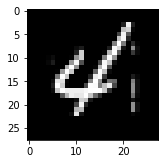

In [26]:
plt.figure(figsize=(8, 5))

plt.subplot(1,3,1)
plt.imshow(test_images[6700].reshape(28,28), cmap="gray") # Import the image
plt.show() # Show the image